This notebook is strongly inspired from this [repo](https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb).

**Please be sure to answer all questions throughout the notebook.**

# Zero-shot classification with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.


CLIP (Contrastive Language–Image Pretraining) is trained using a large dataset containing pairs of images and corresponding textual descriptions. During training, CLIP learns to understand and match these images and texts in a way that aligns with how humans perceive them. It uses two neural networks: one for processing the images (the vision encoder) and another for processing the text (the language encoder). These networks are trained simultaneously in a contrastive learning setup, where the model is encouraged to predict which text goes with which image from a batch of many possible combinations.


In more details, for each batch of training data, CLIP generates embeddings for all images using its image encoder and for all texts using its text encoder. These embeddings are then used to compute a similarity score between each image and each piece of text in the batch. This is typically done using a dot product, resulting in a matrix where each entry represents the similarity between a specific image and a specific piece of text (see figure below). In this matrix, diagonal elements represent matches (correct pairs of image and text), while off-diagonal elements represent mismatches (incorrect pairs).

![](https://images.openai.com/blob/fbc4f633-9ad4-4dc2-bd94-0b6f1feee22f/overview-a.svg?width=10&height=10&quality=50)


More details about CLIP can be found in its orginal paper available [here](https://arxiv.org/pdf/2103.00020.pdf).

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [4]:
! pip install "setuptools<70.0.0"
! pip install ftfy regex tqdm
! pip install "openai-clip"

In [5]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [6]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.10.0+cu128


# Loading the model
 The clip model can be implemented with different backbone networks (either Resnet or Vision Transformers). `clip.available_models()` will list the names of available CLIP models.

In [7]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In this lab, we will employ the ResNet50 backbone eventhough in many benchmarks, ViTs perform better.

In [8]:
# Load the CLIP model with the "RN50" architecture.
# 'model' is the CLIP model, and 'preprocess' is the preprocessing function for input images.
model, preprocess = clip.load("RN50")

# Move the model to the GPU (for faster computation) and set it to evaluation mode.
# Evaluation mode disables layers like dropout and batch normalization that are only used during training.
model.cuda().eval()

# 'input_resolution' stores the size of the image input that the model expects.
# This is important because CLIP requires a specific input image resolution.
input_resolution = model.visual.input_resolution

# 'context_length' indicates the maximum number of tokens (words) that the text encoder can process.
# This is relevant for understanding the limitations on the length of text descriptions that can be processed.
context_length = model.context_length

# 'vocab_size' is the number of unique tokens (words) that the text encoder of the model understands.
# It gives an idea of the diversity of the language that the model can process.
vocab_size = model.vocab_size


print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [9]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f7ed5c3ade0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

**Question:** Can you explain the origin of the specific mean and standard deviation values that are hard-coded in the model?

**Answer**: Those values are hard-coded in CLIP because they were calculated from the specific dataset used to train the CLIP model. It ensures that input images have similar statistical properties to the training data, which helps the model perform optimally.

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [10]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

**Question** How many words are in the input sentence? how many token do we get? why?

**Answer**: The input sentence has 2 worlds, but we get 5 token, because we also have :
- 2 token for the sentence's start and sentence's end (49406 and 4907),
- 1 token for the "!" (256)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [11]:
! pip install scikit-image matplotlib

In [12]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

Let's display the images.

In [13]:
! pip install pooch
! python -c 'import skimage as ski; ski.data.download_all()'

/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


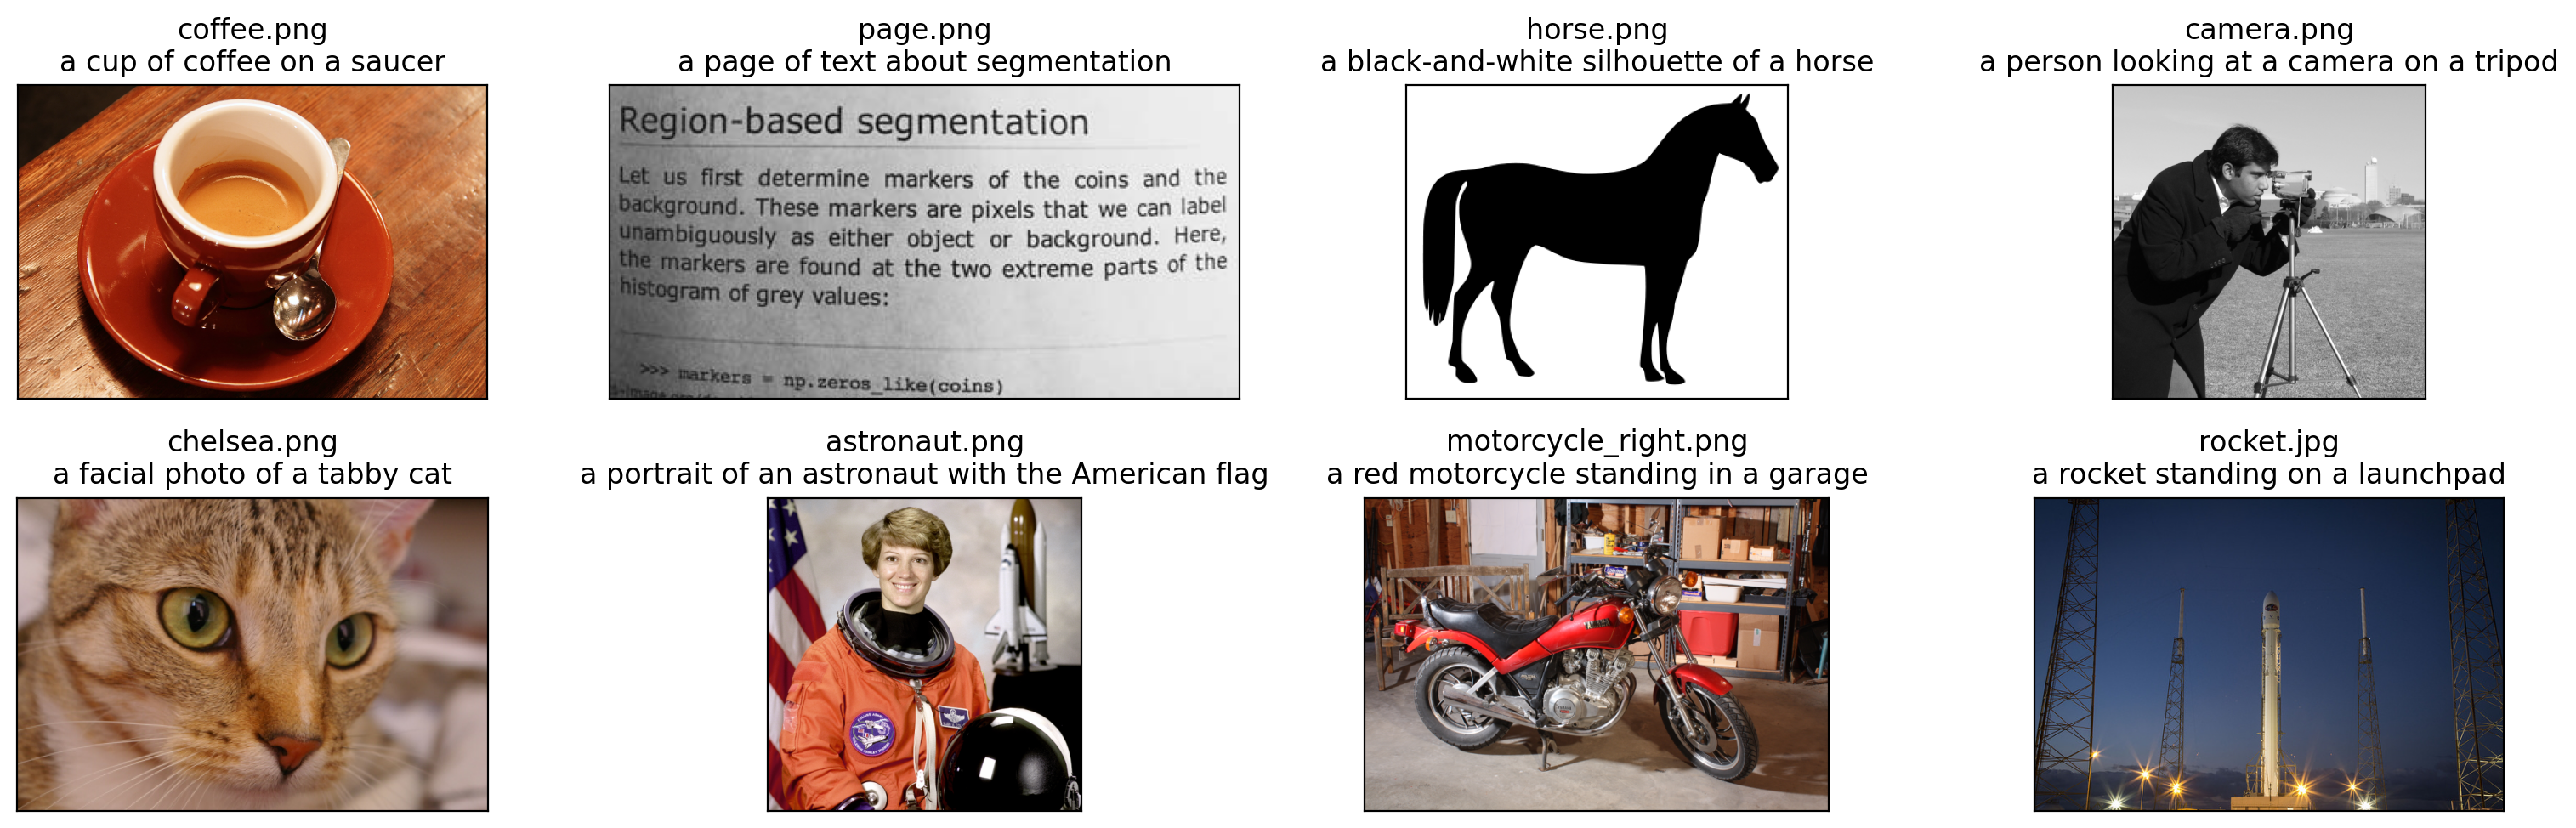

In [14]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [15]:
! ls /root/.cache/

ls: cannot access '/root/.cache/': Permission denied


In [16]:
!sudo find / -type d -path "*/scikit-image/0.24.0/data" 2>/dev/null

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [17]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [18]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [19]:
# TO DO
# Normalize the image features
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
# Normalize the text features
text_features = text_features / text_features.norm(dim=-1, keepdim=True)
# Calculate dot product
similarity = (image_features @ text_features.T)

In [20]:
similarity

tensor([[0.2436, 0.1396, 0.1068, 0.1225, 0.1369, 0.0866, 0.0840, 0.1039],
        [0.1171, 0.2771, 0.1525, 0.1260, 0.1319, 0.0751, 0.0546, 0.1112],
        [0.1093, 0.1414, 0.2970, 0.1409, 0.1205, 0.1075, 0.1141, 0.1244],
        [0.1126, 0.1195, 0.1555, 0.2396, 0.1154, 0.1436, 0.0486, 0.1806],
        [0.1353, 0.1454, 0.0760, 0.1673, 0.2614, 0.0978, 0.0922, 0.1458],
        [0.1114, 0.1019, 0.0757, 0.1297, 0.1455, 0.2297, 0.1018, 0.1654],
        [0.0832, 0.0796, 0.0628, 0.0813, 0.0715, 0.0738, 0.2702, 0.1193],
        [0.0698, 0.1036, 0.0773, 0.1317, 0.0918, 0.1550, 0.0486, 0.2360]],
       device='cuda:0')

Text(0.5, 1.0, 'Cosine similarity between text and image features')

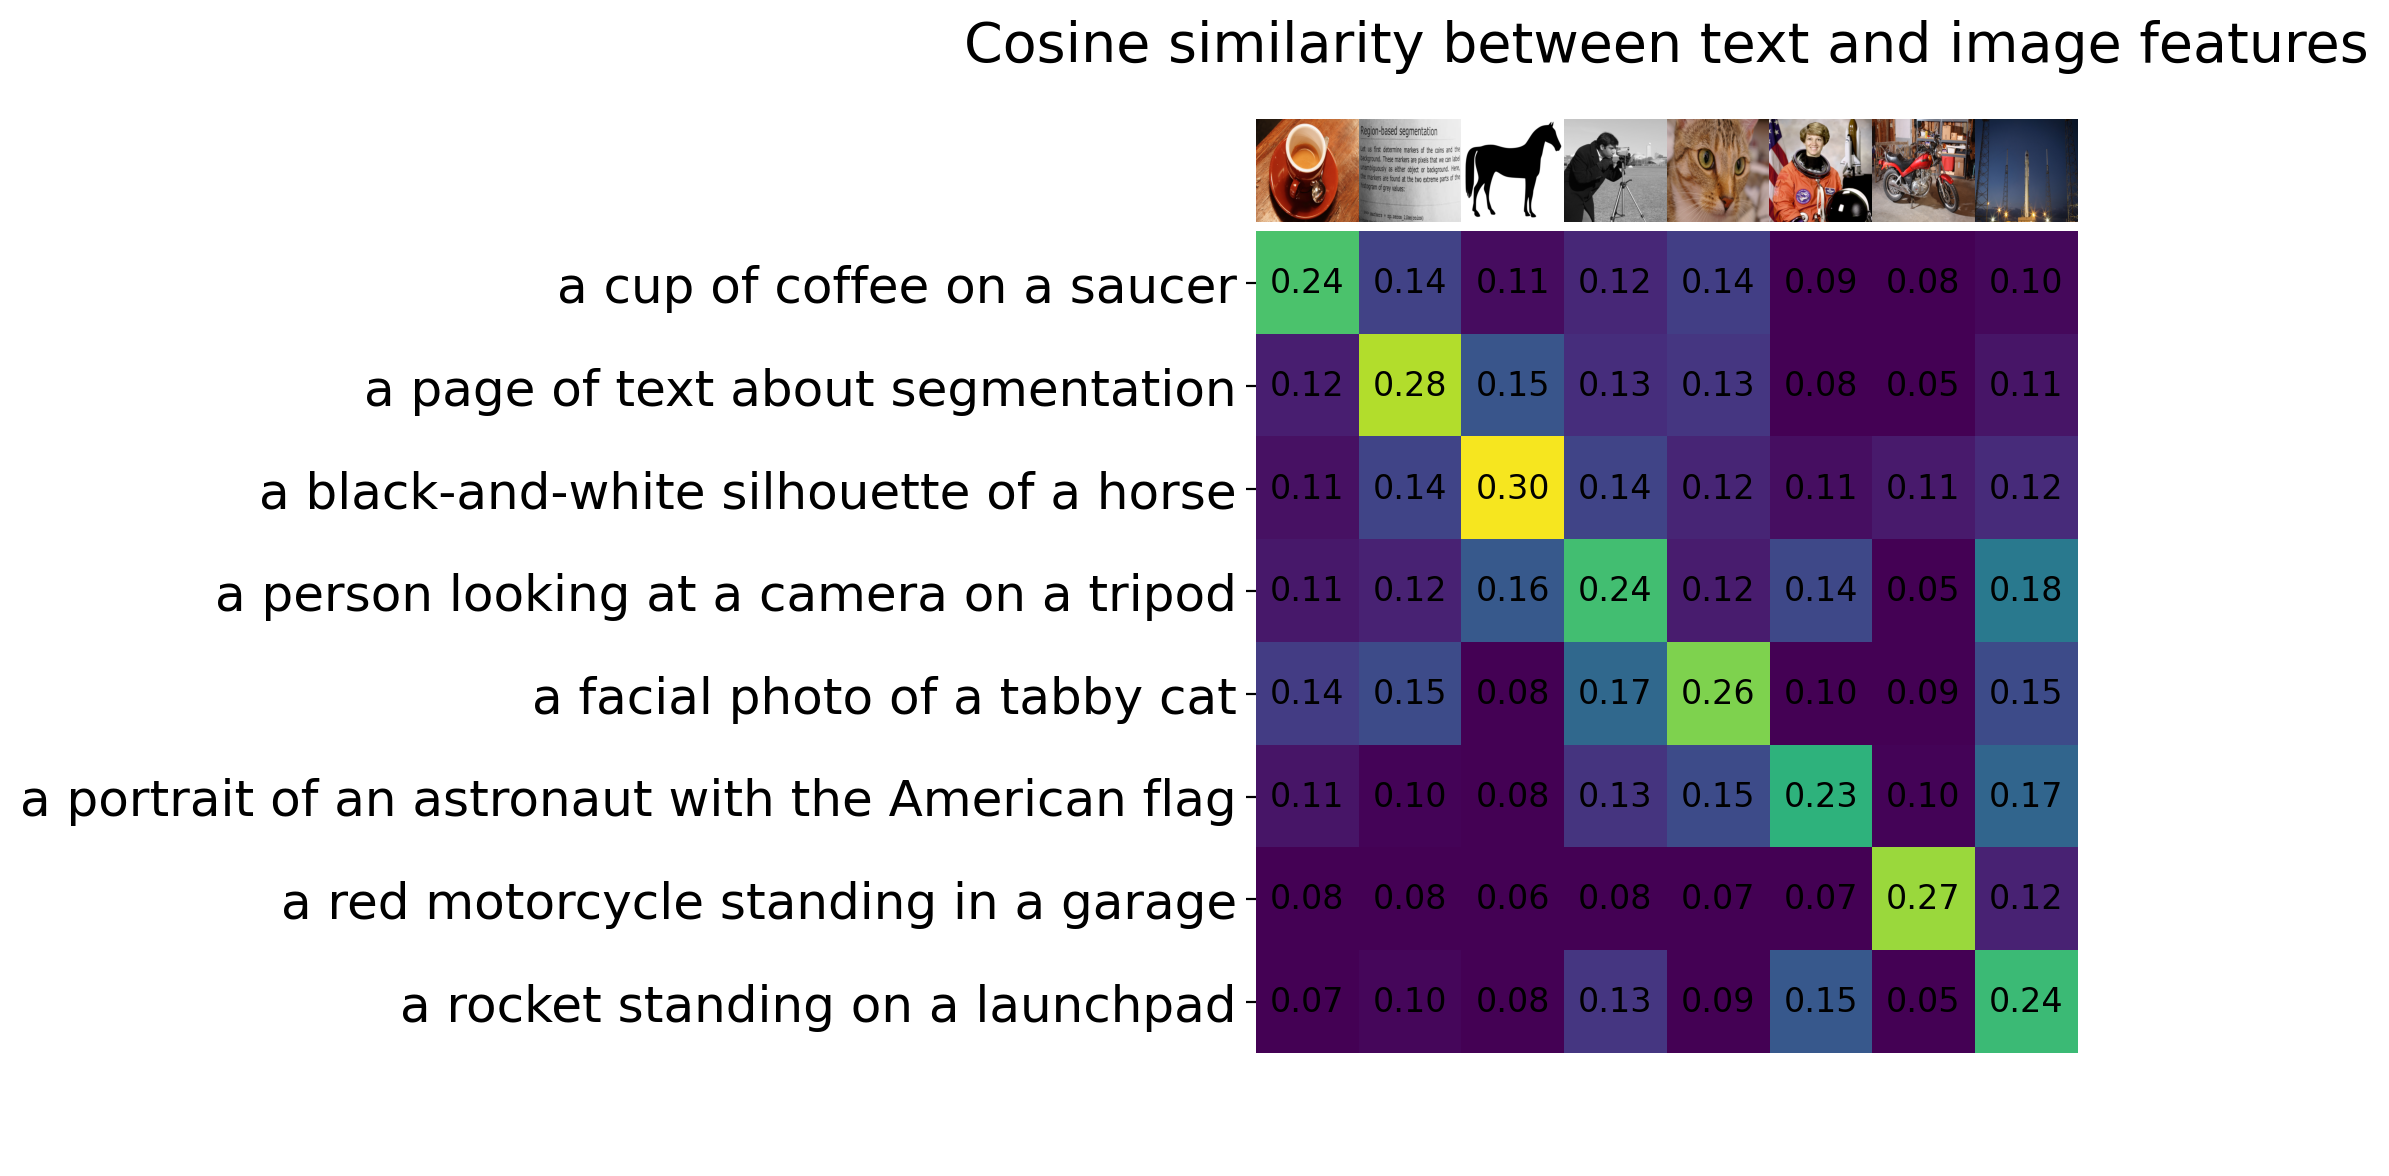

In [21]:
count = len(descriptions)

plt.figure(figsize=(10, 7))
plt.imshow(similarity.cpu().numpy(), vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

**Question 1:** We observe that the highest values are in the diagonal. What does it mean?


**Answer**: The highest values being in the diagonal means each image is most similar to its own text description.
It demonstrates CLIP's ability to understand non trivial features and thus align visual and textual representations

# Zero-Shot Image Classification

Now we're gonna evaluate CLIP for zero-shot classification using the class on the cifar 10 which is a very pobular dataset. We will use the cosine similarity (times 100) as the logits to the softmax operation. We could also simply select the nearest class but this soultion provides probability scores and returns the same output classes.

We start with downloading the dataset and preparing some templates we will use as prompts for classification.

In [22]:
import torch
import clip
import os
from torchvision.datasets import  CIFAR10
from torchvision import datasets, transforms
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device)


cifar10 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False)
cifar10_classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck',]
cifar10_templates = [
        'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]




/opt/python/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


We provide an accuracy function.

In [23]:
@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res


Let's compute the text embeddings which will be used as classifiers that predicts logits. We take the mean of all the classifiers.

In [24]:
@torch.no_grad()
def extract_text_features():

    model.to(device)
    model.eval()

    zeroshot_weights = []

    # Iterate over the class names in CIFAR-10.
    for classname in cifar10_classes:
        # TO DO
        # Generate text prompts for each class using predefined templates.
        # This expands each class name into a variety of descriptive texts.
        texts = [template.format(classname) for template in cifar10_templates]

        # Tokenize the texts (convert text into a format suitable for the CLIP model) and move them to the device.
        texts = clip.tokenize(texts).to(device)

        # Encode the tokenized texts into embeddings (text feature vectors) using the CLIP model.
        class_embeddings = model.encode_text(texts)

        # Normalize the embeddings to unit length for each embedding vector.
        class_embeddings = class_embeddings/class_embeddings.norm(dim=-1, keepdim=True)

        # Average the embeddings for the current class to get a single representative embedding.
        class_embedding = class_embeddings.mean(dim=0)

        # Normalize the averaged embedding vector to unit length.
        class_embedding = class_embedding/class_embedding.norm()

        # Add the normalized, averaged embedding to the list of zero-shot weights.
        zeroshot_weights.append(class_embedding)

    # Stack all the class embeddings along the second dimension and move to the device.
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)

    # Return the matrix of zero-shot weights.
    return zeroshot_weights


Now, we can iterate over the entire test set and compute the total accuracy.



In [25]:
# extract image feature
image_features = []
image_labels = []
for image, class_id in cifar10:
    # Preprocess the image and add a batch dimension (unsqueeze) before sending it to the device (GPU/CPU).
    image_input = preprocess(image).unsqueeze(0).to(device)
    # TO DO
    # Compute the image features

    #...
    with torch.no_grad():
        image_feature = model.encode_image(image_input)
        image_feature = image_feature / image_feature.norm(dim=-1, keepdim=True)

    # Append the normalized feature vector and the corresponding class ID to their respective lists.
    image_features.append(image_feature)
    image_labels.append(class_id)

# Stack all the individual feature vectors into a single tensor.
# The 'dim=1' argument stacks the tensors along the second dimension (batch dimension).
image_features = torch.stack(image_features, dim=1).to(device)

# Squeeze the batch dimension out since we are left with a single batch after stacking.
image_features = image_features.squeeze(dim=0)


# extract text feature
text_features = extract_text_features()

# compute top-1 accuracy
logits = (100. * image_features @ text_features).softmax(dim=-1)
image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)
top1_acc = accuracy(logits, image_labels, (1,))
print(f'top-1 accuracy for CIFAR10: {top1_acc[0]:.3f}')


top-1 accuracy for CIFAR10: 71.520


**Question** what is the impact of using multiple templates? (You don't need to run additional experiments).

**Answer**: Using multiple templates improves zero-shot classification accuracy :

- It makes the text embeddings more robust to variations in phrasing
- It reduces variance by averaging embeddings from multiple prompts

In [26]:
import gc
torch.cuda.empty_cache()
gc.collect()

260

In [27]:
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

transform = transforms.Compose([
    transforms.Resize((model.visual.input_resolution, model.visual.input_resolution)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


We will now create a model which extract the clip features and give them to a classification layer. The goal is to finetune this model on our target dataset.

In [28]:
class CLIPFT(torch.nn.Module):
    def __init__(self, clip_model, num_classes, text_features):
        super().__init__()
        #...
        self.clip_model = clip_model
        self.num_classes = num_classes
        
        # Freeze the CLIP model
        for param in self.clip_model.parameters():
            param.requires_grad = False  
        
        # Add a classification head
        feature_dim = self.clip_model.visual.output_dim
        self.classifier = torch.nn.Linear(feature_dim, num_classes, bias=False)
        
        # Initialize with text embeddings, and not random weights!
        self.classifier.weight.data = text_features.clone().detach().T.float()
    
    def train(self, mode=True):
        """Override to keep CLIP in eval mode"""
        super().train(mode)
        
        self.clip_model.eval()
        self.classifier.train(mode)
        
        return self

    def forward(self, x):
        #...
        with torch.no_grad():
            features = self.clip_model.encode_image(x).float()
            features = features / features.norm(dim=-1, keepdim=True)

        return 100.0*self.classifier(features)

num_classes = 10
modelFT = CLIPFT(model, num_classes, text_features).to(device) #..

Now let's implement the main training loop.
Chose the right trianing loss and define the optimizer as Adam, a popular choice for deep learning models, with a learning rate of 0.0001.
To save time, we recommend training for 1 epoch only (which takes about 10 minutes).

In [29]:
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()  #..
optimizer = torch.optim.Adam(modelFT.classifier.parameters(), lr=0.0001)  #..


# Set the number of epochs, i.e., the number of times the entire dataset is passed through the model.
num_epochs = 1

# Start the training loop over the specified number of epochs.
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    # Set the model to training mode. This enables layers like dropout and batch normalization to function correctly during training.
    modelFT.train()

    # Iterate over the training data loader. Each iteration provides a batch of 'images' and their corresponding 'labels'.
    for images, labels in train_loader:
        #complete the loop
        #...
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = modelFT(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()


Epoch [1/1]


Now we can evaluate our model.

In [30]:
modelFT.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelFT(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the CIFAR-10 test images: {100 * correct / total}%')


Accuracy of the model on the CIFAR-10 test images: 83.9%


How does the fine-tuned model's performance on CIFAR-10 compare with its zero-shot performance? And how does our model stand against the best-performing models on CIFAR-10 (you probably need to google to know state-of-the-art performance)?

**Answer**: The fine-tuned model achieves 84% accuracy on CIFAR-10, which is significantly better than the zero-shot performance (~71%). However, state-of-the-art models on CIFAR-10 (like EfficientNet, ResNet variants with advanced training techniques) can achieve 99%+ accuracy. Our model performs well but not at state-of-the-art level because:

- We're only fine-tuning the classification head, not the backbone
- We're using simple training with only 1 epoch
- Advanced techniques like data augmentation, learning rate scheduling, etc., are not used

# Few Shot Learning

We now advance to Few-Shot Learning (FSL). In this regime, we assume access to a limited labeled 'support set' (e.g., just 1, 5, or 10 images per class) during training, rather than a massive dataset. Our goal is to leverage these scarce examples to adapt our model and significantly improve performance over the Zero-Shot baseline. In the following cells, we will implement a utility function to generate specifically sized $K$-shot training splits from the Flowers102 dataset. We will continue to utilize the pre-trained CLIP backbone for feature extraction, demonstrating its ability to learn high-quality representations from minimal data. First let's load the dataset and see the zero shot performance of the CLIP model on the Flowers102 Dataset which we'll be using for this case.

In [31]:
import torch
import clip
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

transform = transforms.Compose([
    transforms.Resize((model.visual.input_resolution, model.visual.input_resolution)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

flowers102_classes = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly',
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue',
    'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium',
    'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?',
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
    'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy',
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple',
    'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
    'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
    'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
    'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea',
    'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily'
]

flowers_templates = [
    'a photo of a {}.',
    'a photo of a flower called {}.',
    'a photo of the {}.',
    'a close-up photo of a {}.',
    'a photo of a {}, a type of flower.',
]

# Load Datasets
train_dataset = datasets.Flowers102(root="./data", split="train", download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.Flowers102(root="./data", split="test", download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Loaded Flowers102: {len(train_dataset)} training images, {len(test_dataset)} testing images.")

Loaded Flowers102: 1020 training images, 6149 testing images.


### Evaluating Zero Shot Performance on Test Dataset

In [32]:
import torch
import clip
import numpy as np
from tqdm import tqdm

def zeroshot_classifier(model, classnames, templates, device):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames, desc="Building Text Classifier"):
            # To DO (same as before)
            ...
            ...
            texts = [template.format(classname) for template in cifar10_templates]
            texts = clip.tokenize(texts).to(device)
            class_embeddings = model.encode_text(texts)
            class_embeddings = class_embeddings/class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding = class_embedding/class_embedding.norm()

            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [33]:
class_names = flowers102_classes
zeroshot_weights = zeroshot_classifier(model, class_names, flowers_templates, device)
top1_acc = 0
top5_acc = 0
n = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ zeroshot_weights
        acc1, acc5 = accuracy(logits, labels, topk=(1, 5))
        top1_acc += acc1
        top5_acc += acc5
        n += 1

print(f"\nZero-shot CLIP Top-1 Accuracy: {top1_acc.item() / n:.2f}%")
print(f"Zero-shot CLIP Top-5 Accuracy: {top5_acc.item() / n:.2f}%")

Evaluating: 100%|██████████| 49/49 [01:43<00:00,  2.11s/it]


Zero-shot CLIP Top-1 Accuracy: 60.78%
Zero-shot CLIP Top-5 Accuracy: 81.82%


As you can see, the zero shot performance is not optimal and we wish to improve it using few shot learning.

We will create a function to give us seperate train sets for few shot learning.

### Creating Dataloaders : Few Shot

In [34]:
import torch
import numpy as np
import random
from torch.utils.data import Subset, DataLoader

def get_few_shot_train_subset(dataset, k_shots, num_classes, seed=42):
    """
    Samples exactly k_shots per class from the training dataset
    to create a Few-Shot 'Support' set.
    """
    np.random.seed(seed)
    random.seed(seed)
    targets = np.array(dataset._labels)

    selected_indices = []

    for c in range(num_classes):
        # TO DO
        # Find all indices belonging to class 'c'
        ...
        class_indices = np.where(targets == c)[0]
        np.random.shuffle(class_indices)

        if len(class_indices) < k_shots:
            raise ValueError(f"Class {c} has fewer images ({len(class_indices)}) than k_shots ({k_shots}).")

        # Select the first K images
        ...
        selected_indices.extend(class_indices[:k_shots])


    return Subset(dataset, selected_indices)


shot_counts = [1, 2, 4, 8]
few_shot_loaders = {}

print("Creating Few-Shot Loaders...")

for k in shot_counts:
    # TO DO
    # Create the k-shot subset
    k_shot_subset = get_few_shot_train_subset(
        train_dataset,
        k_shots=k,
        num_classes=102,
        seed=42
    )

    loader = DataLoader(k_shot_subset, batch_size=32, shuffle=True)
    few_shot_loaders[k] = loader
    print(f"  - Created {k}-shot loader with {len(k_shot_subset)} total images.")

Creating Few-Shot Loaders...
  - Created 1-shot loader with 102 total images.
  - Created 2-shot loader with 204 total images.
  - Created 4-shot loader with 408 total images.
  - Created 8-shot loader with 816 total images.


In [138]:
few_shot_loaders

{1: <torch.utils.data.dataloader.DataLoader at 0x7f80c98efb50>,
 2: <torch.utils.data.dataloader.DataLoader at 0x7f80c98ef650>,
 4: <torch.utils.data.dataloader.DataLoader at 0x7f81fe4f0a50>,
 8: <torch.utils.data.dataloader.DataLoader at 0x7f81fe4f0850>}

### Evaluation Method

In [35]:
from tqdm import tqdm
def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            # TO DO
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

## Few Shot Learning through Linear Probing

To enhance performance on our specific dataset, we will employ a technique known as Linear Probing. In this approach, we freeze the weights of the massive, pre-trained CLIP backbone and attach a lightweight linear classifier (a single dense layer) to its output. We then train only this new layer on our $K$-shot, $N$-class dataset. This allows us to adapt the powerful visual features learned by CLIP to the specific nuances of the Flowers102 classes.

In [36]:
import torch
import torch.nn as nn
import clip

class CLIPLinearProbe(nn.Module):
    def __init__(self, clip_model, class_names, device):
        super().__init__()
        self.clip_model = clip_model
        self.num_classes = len(class_names)
        # TO DO

        # FREEZE THE BACKBONE
        # ...
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # DEFINE THE CLASSIFIER HEAD
        feature_dim = self.clip_model.visual.output_dim
        self.classifier = nn.Linear(feature_dim, self.num_classes).to(device)

        self.classifier.weight.data = zeroshot_weights.clone().detach().T.float()

    def forward(self, x):
        with torch.no_grad():
            # TO DO
            features = self.clip_model.encode_image(x)
            features = features.float()
        return self.classifier(features)

### Training and Evaluation

The cell below should take around 30 minutes to be executed on colab T4. Therefore, you could first experiment with 1 shot. You should get a performance of around 36.7%.

In [38]:
accuracies = []
for k_shots in [1, 2, 4, 8]:
    print(f"Starting {k_shots}-shot evaluation")

    train_loader = few_shot_loaders[k_shots]

    # TO DO
    # Create a fresh classifier for this run
    model_probe = CLIPLinearProbe(model, flowers102_classes, device).to(device)
    optimizer = torch.optim.AdamW(model_probe.classifier.parameters(), lr=1e-3, weight_decay=1e-2)
    criterion = torch.nn.CrossEntropyLoss()

    # Since data is tiny, we can run more epochs quickly
    model_probe.train()
    for epoch in tqdm(range(200)):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_probe(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on the Test Set
    acc = evaluate_accuracy(model_probe, test_loader, device)
    accuracies.append(acc)
    print(f"{k_shots}-shot Learning: {acc:.2f}% Accuracy")

Starting 1-shot evaluation


100%|██████████| 49/49 [01:50<00:00,  2.25s/it]


1-shot Learning: 38.01% Accuracy
Starting 2-shot evaluation


100%|██████████| 49/49 [01:59<00:00,  2.43s/it]


2-shot Learning: 50.12% Accuracy
Starting 4-shot evaluation


100%|██████████| 49/49 [01:52<00:00,  2.29s/it]


4-shot Learning: 62.24% Accuracy
Starting 8-shot evaluation


100%|██████████| 49/49 [02:00<00:00,  2.45s/it]

8-shot Learning: 74.09% Accuracy


**Results**:
- 1: 38.01%
- 2: 50.12%
- 4: 62.24%
- 8: 74.09%

**Question**: We observe that the 1-shot and 2-shot accuracy is very low when compared to the zero shot case. Why do you think this happens?

**Answer**: The 1-shot and 2-shot accuracy is very low compared to zero-shot because:

- With only 1-2 examples per class, there's high variance in the training data

- The linear classifier can easily overfit to the limited examples

- Random initialization of the linear layer may not align well with CLIP's feature space

- The model lacks enough data to learn a good decision boundary

- Zero-shot CLIP already has strong prior knowledge from pre-training, while linear probing starts from scratch

## Improving Linear Probing through Custom Initializations

While standard Linear Probing yields improvements as the number of shots ($K$) increases, it often struggles in extremely low-data regimes (e.g., 1-shot or 2-shot) due to the volatility of random weight initialization. To mitigate this, we can initialize the classification layer's weights using the Zero-Shot text embeddings generated by CLIP, rather than starting from scratch with random values. This technique, injects CLIP's strong prior semantic knowledge into the classifier before training even begins. In the following section, we will modify our Linear Probe class to accept these pre-computed text embeddings as initialization weights and evaluate the performance gain.

In [42]:
import torch
import torch.nn as nn
import clip

class CLIPLinearProbeT(nn.Module):
    def __init__(self, clip_model, class_names, templates, device, text_init=False):
        super().__init__()
        self.clip_model = clip_model
        self.num_classes = len(class_names)

        # TO DO
        # FREEZE THE BACKBONE
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # DEFINE THE CLASSIFIER HEAD
        feature_dim = self.clip_model.visual.output_dim
        self.classifier = nn.Linear(feature_dim, self.num_classes, bias=False).to(device)

        if text_init:
              print("Initializing classifier weights with text embeddings...")
              text_features = []

              with torch.no_grad():
                  for classname in class_names:
                      # To DO
                      # Create prompts from templates
                      texts = [template.format(classname) for template in templates]
                      # Tokenize
                      texts_tokenized = clip.tokenize(texts).to(device)
                      # Encode Text
                      class_embeddings = self.clip_model.encode_text(texts_tokenized)
                      # Normalize individual template embeddings
                      class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)
                      # Mean over templates
                      class_embedding = class_embeddings.mean(dim=0)
                      # Normalize the final mean embedding
                      class_embedding = class_embedding / class_embedding.norm()
                      text_features.append(class_embedding)

                  # Stack into a tensor
                  text_features = torch.stack(text_features)

                  # Copy to classifier weights
                  self.classifier.weight.data = text_features.clone().detach().float()

    def forward(self, x):
        with torch.no_grad():
            # TO DO
            features = self.clip_model.encode_image(x)
            features = features.float()

        return self.classifier(features)

### Training and Evaluation

The cell below should also take around 30 minutes to be executed on colab T4.

In [44]:
accuracies_2 = []
for k_shots in [1, 2]:  # , 4, 8]:
    print(f"Starting {k_shots}-shot evaluation")

    train_loader = few_shot_loaders[k_shots]

    # TO DO
    # Create a fresh classifier for this run
    model_probe = CLIPLinearProbeT(model, flowers102_classes, flowers_templates, device, text_init=True).to(device)
    optimizer = torch.optim.AdamW(model_probe.classifier.parameters(), lr=1e-3, weight_decay=1e-2)
    criterion = torch.nn.CrossEntropyLoss()

    # Since data is tiny, we can run more epochs quickly
    model_probe.train()
    for epoch in tqdm(range(200)):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_probe(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on the Test Set
    acc = evaluate_accuracy(model_probe, test_loader, device)
    accuracies_2.append(acc)
    print(f"{k_shots}-shot Learning: {acc:.2f}% Accuracy")

Starting 1-shot evaluation
Initializing classifier weights with text embeddings...


100%|██████████| 49/49 [01:55<00:00,  2.36s/it]


1-shot Learning: 38.27% Accuracy
Starting 2-shot evaluation
Initializing classifier weights with text embeddings...


100%|██████████| 49/49 [01:56<00:00,  2.37s/it]

2-shot Learning: 50.04% Accuracy


In [ ]:
for k_shots in [4, 8]:  # , 4, 8]:
    print(f"Starting {k_shots}-shot evaluation")

    train_loader = few_shot_loaders[k_shots]

    # TO DO
    # Create a fresh classifier for this run
    model_probe = CLIPLinearProbeT(model, flowers102_classes, flowers_templates, device, text_init=True).to(device)
    optimizer = torch.optim.AdamW(model_probe.classifier.parameters(), lr=1e-3, weight_decay=1e-2)
    criterion = torch.nn.CrossEntropyLoss()

    # Since data is tiny, we can run more epochs quickly
    model_probe.train()
    for epoch in tqdm(range(200)):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_probe(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on the Test Set
    acc = evaluate_accuracy(model_probe, test_loader, device)
    accuracies_2.append(acc)
    print(f"{k_shots}-shot Learning: {acc:.2f}% Accuracy")

**Results**:
- 1: 38.27%
- 2: 50.04%
- 4: %
- 8: %


# Tip-Adapter - Training-free Adaption of CLIP

Tip-Adapter adapts the pre-trained CLIP model for few-shot classification by constructing a training-free key-value cache model from the few-shot support set. Given a support set of $K$-shot $N$-class training samples, the method first extracts their L2-normalized visual features using CLIP's visual encoder to form the keys, denoted as matrix $F_{train} \in \mathbb{R}^{NK \times C}$. The corresponding labels are converted into one-hot encodings to form the values, denoted as $L_{train} \in \mathbb{R}^{NK \times N}$.

During inference, for a test image with feature $f_{test} \in \mathbb{R}^{1 \times C}$, the model retrieves knowledge from this cache by calculating the affinity between the test feature and the cached keys using an exponential function: $A = \exp(-\beta(1 - f_{test}F_{train}^T))$, where $\beta$ is a sharpening hyper-parameter. The final prediction is a weighted combination of the retrieved cache knowledge and the original zero-shot CLIP prediction:

$$
\text{logits} = \alpha A L_{train} + f_{test}W_c^T
$$

where:
* $\alpha$ is a residual ratio that balances the two terms.
* $W_c$ represents the weights of CLIP's original text classifier.

This effectively allows the model to "lookup" similar few-shot examples to refine its prediction without updating any backpropagation weights.



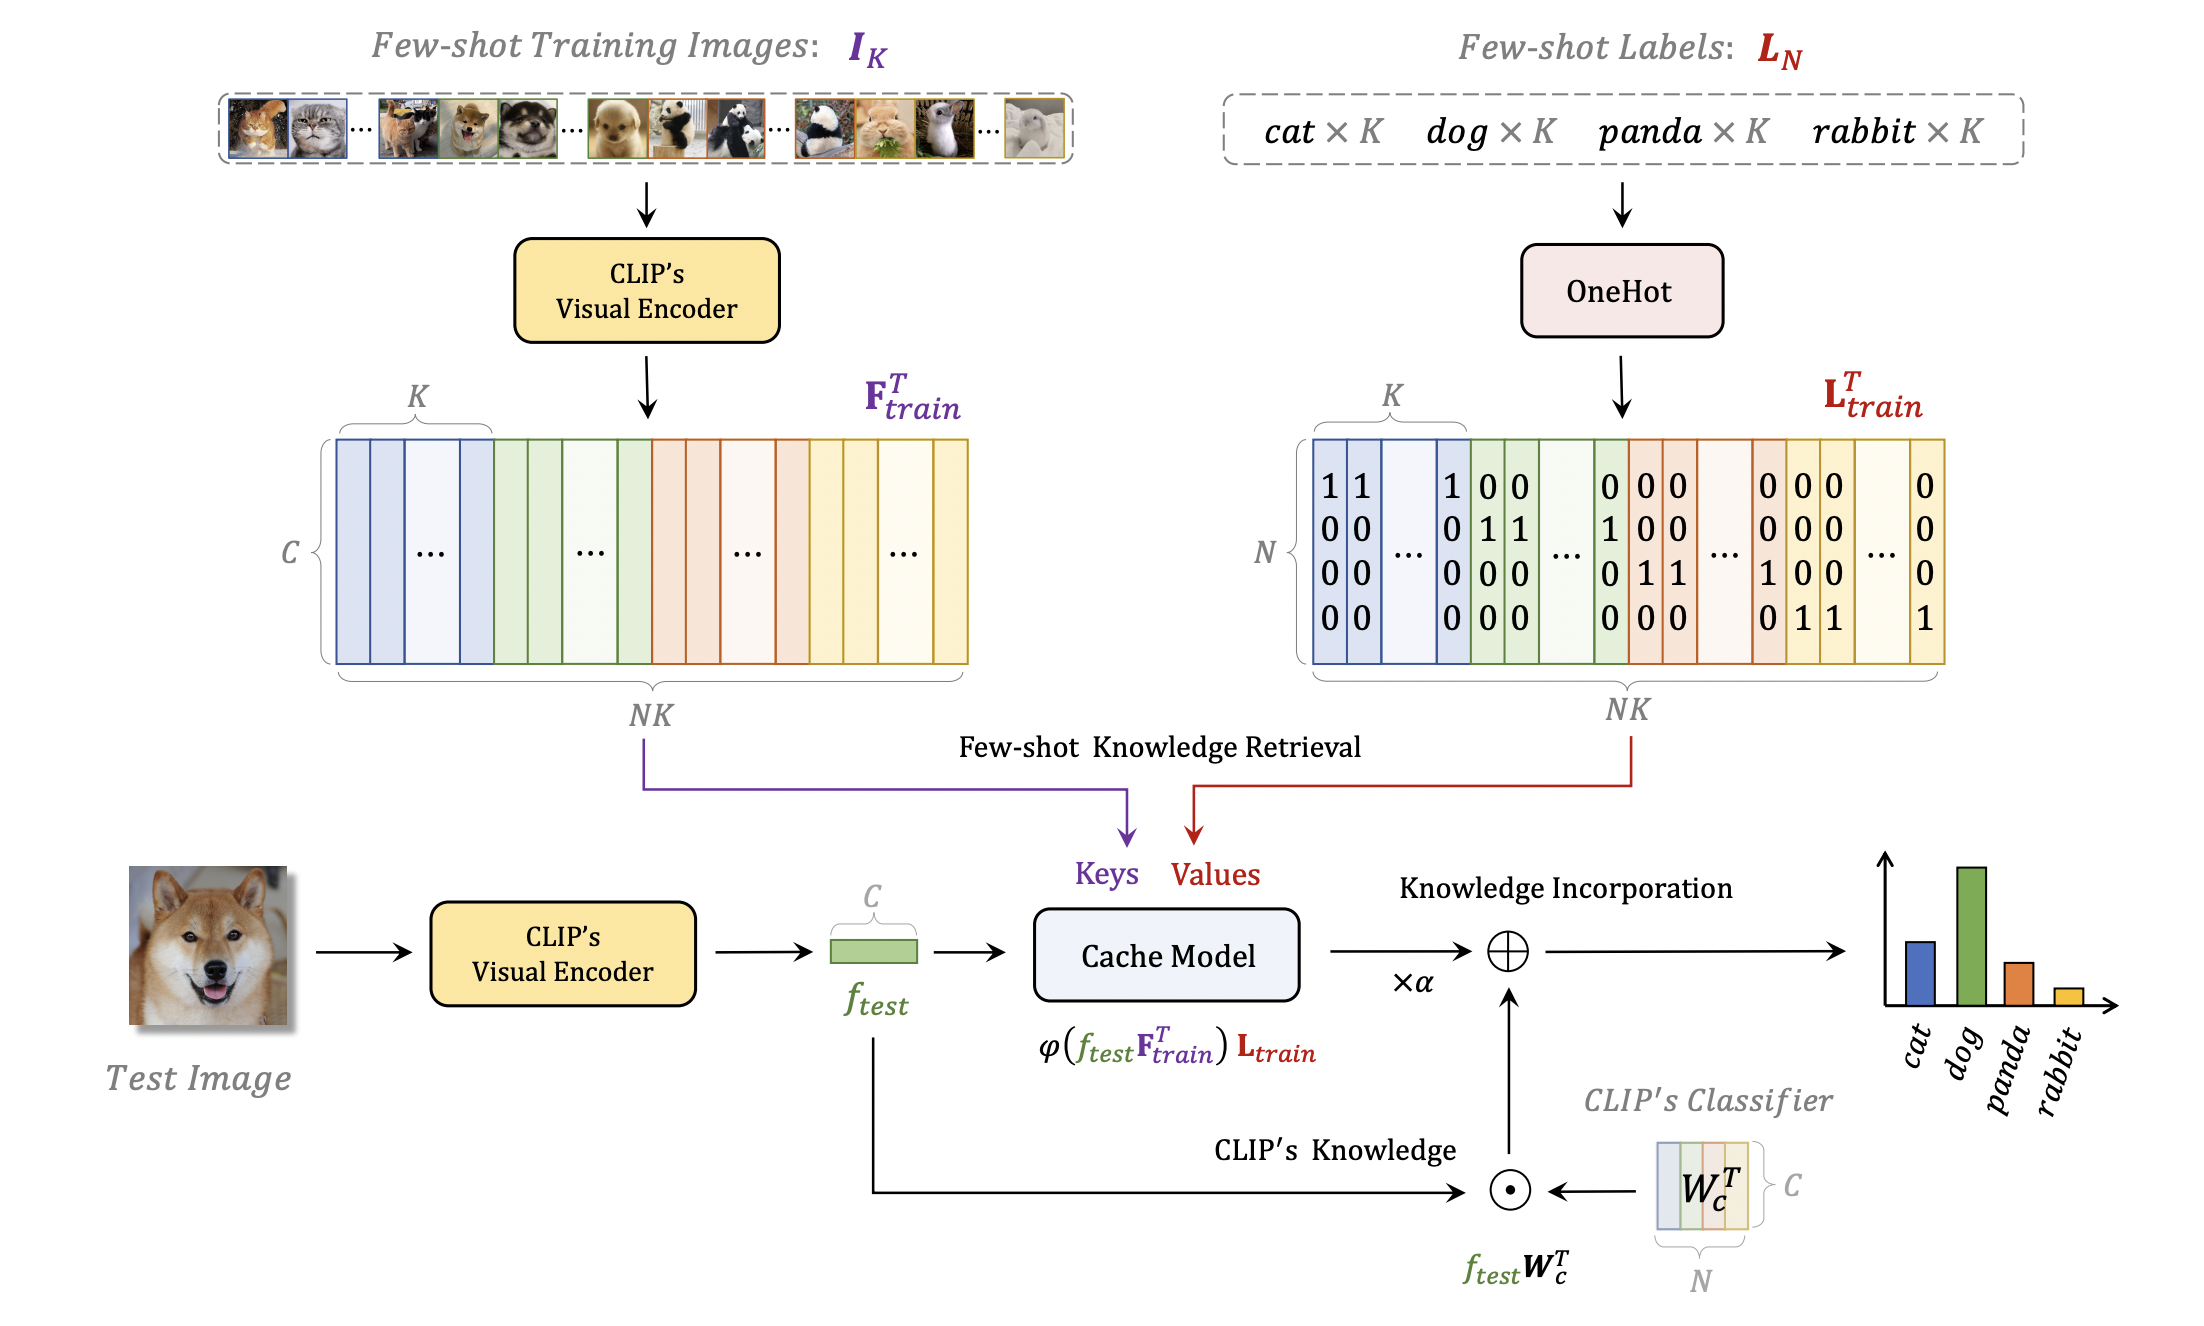

This code has been adapted from https://github.com/gaopengcuhk/Tip-Adapter. Please have a look at their repo to have a better understanding. Also, do have a look at their paper: https://arxiv.org/abs/2111.03930

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip

class TipAdapter(nn.Module):
    def __init__(self, clip_model, class_names, templates, device, alpha=1.0, beta=5.5):
        super().__init__()
        self.clip_model = clip_model
        self.device = device
        self.alpha = alpha
        self.beta = beta
        self.class_names = class_names
        self.templates = templates

        # TO DO
        # Generate text weights for zero shot classification
        self.text_weights = self._get_text_weights()

        self.cache_keys = None
        self.cache_values = None

    def _get_text_weights(self):
        with torch.no_grad():
            text_features = []
            for classname in self.class_names:
                # TO DO (same as before)
                texts = [template.format(classname) for template in self.templates]
                texts = clip.tokenize(texts).to(self.device)
                class_embeddings = self.clip_model.encode_text(texts)
                class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)
                class_embedding = class_embeddings.mean(dim=0)
                class_embedding = class_embedding / class_embedding.norm()
                text_features.append(class_embedding)
            return torch.stack(text_features).t()

    def build_cache(self, train_loader):
        cache_keys = []
        cache_values = []

        with torch.no_grad():
            for images, labels in train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                # TO DO
                # Visual Features (Keys)
                features = self.clip_model.encode_image(images)
                # Normalize
                features = features / features.norm(dim=-1, keepdim=True)
                cache_keys.append(features)

                # One-Hot Labels (Values)
                one_hot = F.one_hot(labels, num_classes=len(self.class_names)).float()
                cache_values.append(one_hot)

        # Concatenate
        self.cache_keys = torch.cat(cache_keys, dim=0)
        self.cache_values = torch.cat(cache_values, dim=0)

        self.cache_keys = self.cache_keys.to(self.text_weights.dtype)
        self.cache_values = self.cache_values.to(self.text_weights.dtype)

        print(f"Keys: {self.cache_keys.shape}, Values: {self.cache_values.shape}")

    def forward(self, x):
        with torch.no_grad():
            # TO DO
            # Extract Test Features and Normalize
            image_features = self.clip_model.encode_image(x)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # Zero-Shot Logits
            clip_logits = 100.0 * image_features @ self.text_weights

            # affinity calculation
            affinity = image_features @ self.cache_keys.t()

            # exponential sharpening
            cache_logits = torch.exp(self.beta * affinity) @ self.cache_values

            # Combine
            tip_logits = clip_logits + self.alpha * cache_logits

            return tip_logits

### Evaluation

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

In [47]:
from tqdm import tqdm
acc_tip = []
# Initialize Model
for k in few_shot_loaders.keys():
  model_tip = TipAdapter(model, flowers102_classes, flowers_templates, device, alpha=1.0, beta=5.5).to(device)

  # TO DO
  # Build the Cache (This replaces the entire training loop!)
  model_tip.build_cache(few_shot_loaders[k])

  acc = evaluate_accuracy(model_tip, test_loader, device)
  print(f"Tip-Adapter Accuracy {k}-shot: {acc:.2f}%")
  acc_tip.append(acc)

Keys: torch.Size([102, 1024]), Values: torch.Size([102, 102])


100%|██████████| 49/49 [02:08<00:00,  2.61s/it]


Tip-Adapter Accuracy 1-shot: 61.07%
Keys: torch.Size([204, 1024]), Values: torch.Size([204, 102])


100%|██████████| 49/49 [02:06<00:00,  2.58s/it]


Tip-Adapter Accuracy 2-shot: 69.17%
Keys: torch.Size([408, 1024]), Values: torch.Size([408, 102])


100%|██████████| 49/49 [02:07<00:00,  2.60s/it]


Tip-Adapter Accuracy 4-shot: 72.09%
Keys: torch.Size([816, 1024]), Values: torch.Size([816, 102])


100%|██████████| 49/49 [02:05<00:00,  2.55s/it]

Tip-Adapter Accuracy 8-shot: 77.31%


**Results**:
- 1: 61.07%
- 2: 69.17%
- 4: 72.09%
- 8: 77.31%


# Finetuning Tip-Adapter : Tip-Adapter-F

As seen before Tip-Adapter performs well but still it lags behind other methods when the number of shots increases. To mitigate this we will use Tip-Adapter-F which is a fine-tuned variant of the training-free Tip-Adapter that significantly enhances few-shot classification performance by updating the keys within its cache model.

Instead of keeping the cache fixed, Tip-Adapter-F unfreezes the cached keys $F_{train}$ and treats them as initialized learnable parameters, which are then optimized via Stochastic Gradient Descent (SGD).

Crucially, the corresponding cached values $L_{train}$ and the pre-trained CLIP encoders remain frozen to prevent overfitting and preserve prior knowledge.

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from tqdm import tqdm

class TipAdapterF(nn.Module):
    def __init__(self, clip_model, class_names, templates, device, alpha=1.0, beta=5.5):
        super().__init__()
        self.clip_model = clip_model
        self.device = device
        self.alpha = alpha
        self.beta = beta
        self.class_names = class_names
        self.templates = templates

        # TO DO
        # Freeze CLIP
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.text_weights = self._get_text_weights().float()

        self.adapter = None

    def _get_text_weights(self):
        with torch.no_grad():
            text_features = []
            for classname in self.class_names:
                # TO DO (same as before)
                texts = [template.format(classname) for template in self.templates]
                texts = clip.tokenize(texts).to(self.device)
                class_embeddings = self.clip_model.encode_text(texts)
                class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)
                class_embedding = class_embeddings.mean(dim=0)
                class_embedding = class_embedding / class_embedding.norm()
                text_features.append(class_embedding)
            return torch.stack(text_features).t()

    def init_adapter(self, train_loader):
        cache_keys = []
        cache_values = []

        self.clip_model.eval()
        with torch.no_grad():
            for images, labels in train_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                # TO DO
                # Visual Features (Keys)
                features = self.clip_model.encode_image(images).float()
                # Normalize
                features = features / features.norm(dim=-1, keepdim=True)
                cache_keys.append(features)

                # One-Hot Labels (Values)
                one_hot = F.one_hot(labels, num_classes=len(self.class_names)).float()
                cache_values.append(one_hot)

        # Concatenate
        cache_keys = torch.cat(cache_keys, dim=0)
        cache_values = torch.cat(cache_values, dim=0)
        cache_keys = cache_keys.to(self.clip_model.dtype).float()
        cache_values = cache_values.to(self.clip_model.dtype).float()

        # Create nn.Linear Adapter (Keep the data type as self.clip_model.dtype and move to device)
        self.adapter = nn.Linear(cache_keys.shape[1], cache_keys.shape[0], bias=False, dtype=self.clip_model.dtype).to(self.device)
        self.adapter.weight.data = cache_keys

        # Save values as buffer
        self.register_buffer('cache_values', cache_values)

    def forward(self, x):
        with torch.no_grad():
            # TO DO
            # Extract test features and Normalize
            image_features = self.clip_model.encode_image(x).float()
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Zero-Shot Logits
        clip_logits = 100.0 * image_features @ self.text_weights

        # Affinity (Process image features through Linear Adapter)
        affinity = self.adapter(image_features.float())

        # Cache Logits
        cache_logits = (-self.beta * (1 - affinity)).exp() @ self.cache_values

        tip_logits = clip_logits + self.alpha * cache_logits

        return tip_logits

### Training Method

In [61]:
def run_tip_adapter_f(train_loader, test_loader, model, class_names, templates, device, epochs=20, lr=0.001):

    # Initialize Model
    tip_model = TipAdapterF(model, class_names, templates, device, alpha=1.0, beta=5.5)
    tip_model.init_adapter(train_loader)

    optimizer = torch.optim.AdamW(tip_model.adapter.parameters(), lr=lr, eps=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))
    criterion = nn.CrossEntropyLoss()

    print(f"Start Fine-tuning for {epochs} epochs...")

    for epoch in tqdm(range(epochs)):
        tip_model.adapter.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            output = tip_model(images)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

    return tip_model

### Evaluation

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)
acc_tipf = []
for k in few_shot_loaders.keys():
  finetuned_model = run_tip_adapter_f(
    train_loader= few_shot_loaders[k],
    test_loader=test_loader,
    model=model,
    class_names=flowers102_classes,
    templates=flowers_templates,
    device=device,
    epochs=20,
    lr=0.001
)

  finetuned_model.eval()
  acc = evaluate_accuracy(finetuned_model, test_loader, device)
  print(f"Test Accuracy {k}-shot: {acc:.2f}%")
  acc_tipf.append(acc)

Start Fine-tuning for 20 epochs...


100%|██████████| 49/49 [01:55<00:00,  2.37s/it]


Test Accuracy 1-shot: 68.29%
Start Fine-tuning for 20 epochs...


100%|██████████| 49/49 [01:50<00:00,  2.26s/it]


Test Accuracy 2-shot: 78.73%
Start Fine-tuning for 20 epochs...


100%|██████████| 49/49 [01:47<00:00,  2.18s/it]


Test Accuracy 4-shot: 85.88%
Start Fine-tuning for 20 epochs...


100%|██████████| 49/49 [01:54<00:00,  2.34s/it]

Test Accuracy 8-shot: 91.43%


**Results**:
- 1: 68.29%
- 2: 69.17%
- 4: 85.88%
- 8: 91.43%


**Question** : Compare the performances of all the above approaches (4) on a graph. Give suitable observations and conclusions. Which approach was the most efficient one? Why? Each approach would have 4 models (1, 2, 4 and 8 shot).

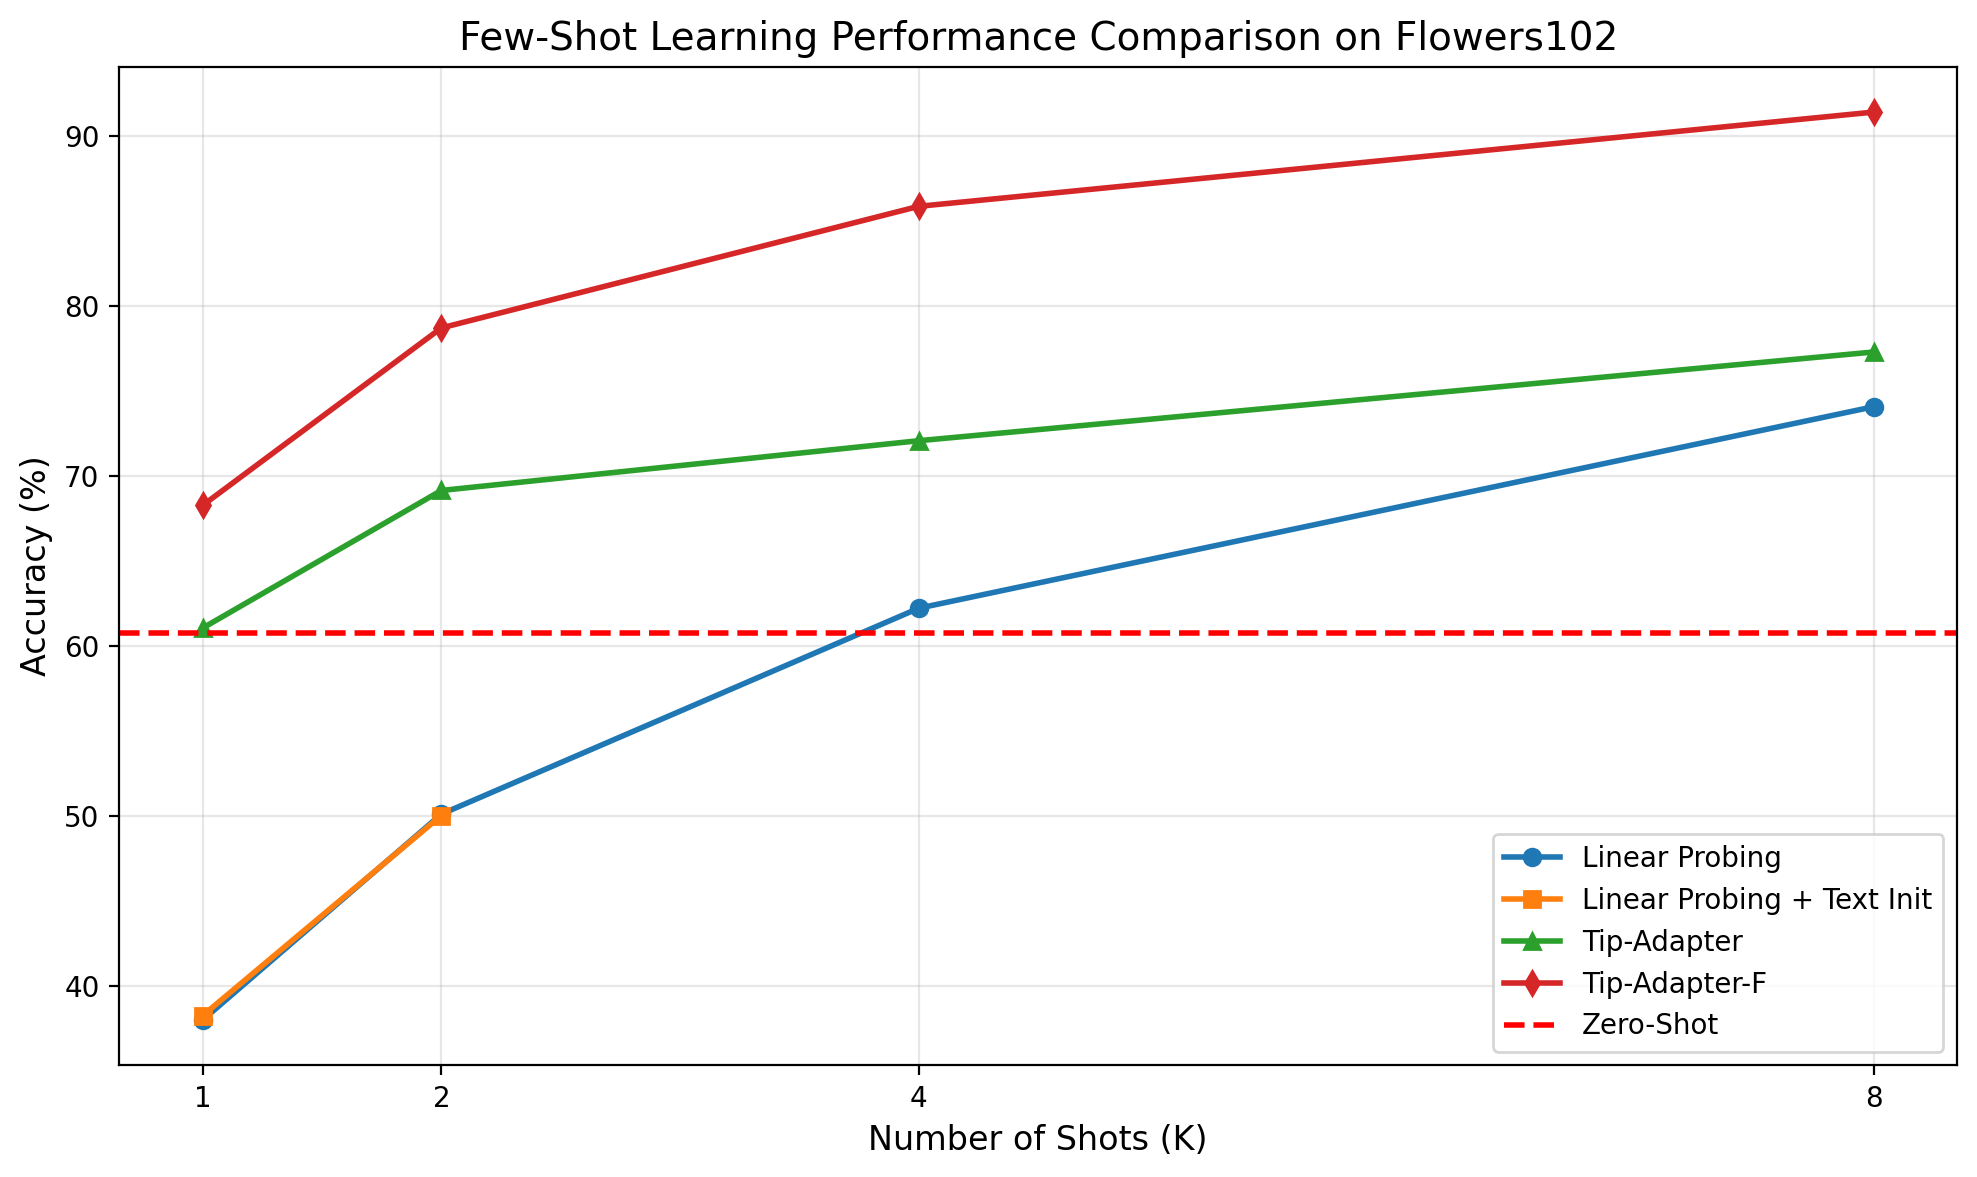


FEW-SHOT LEARNING PERFORMANCE COMPARISON
Method                    Available Shots Accuracies          
------------------------------------------------------------
Zero-Shot                 all             60.8%
Linear Probing            [1, 2, 4, 8]    ['38.0%', '50.1%', '62.2%', '74.1%']
Linear Probing + Text     [1, 2]          ['38.3%', '50.0%']  
Tip-Adapter               [1, 2, 4, 8]    ['61.1%', '69.2%', '72.1%', '77.3%']
Tip-Adapter-F             [1, 2, 4, 8]    ['68.3%', '78.7%', '85.9%', '91.4%']


In [64]:
import matplotlib.pyplot as plt

zero_shot_acc = 60.78
linear_probe_acc = accuracies
linear_probe_text_acc = accuracies_2  # - only 2 values because it was taking too much time...
tip_adapter_acc = acc_tip
tip_adapter_f_acc = acc_tipf

# Create plot
plt.figure(figsize=(10, 6))

# Plot each method with its available shots
if linear_probe_acc:
    shots_lp = [1, 2, 4, 8][:len(linear_probe_acc)]
    plt.plot(shots_lp, linear_probe_acc, 'o-', label='Linear Probing', linewidth=2)

if linear_probe_text_acc:
    shots_lpt = [1, 2, 4, 8][:len(linear_probe_text_acc)]
    plt.plot(shots_lpt, linear_probe_text_acc, 's-', label='Linear Probing + Text Init', linewidth=2)

if tip_adapter_acc:
    shots_ta = [1, 2, 4, 8][:len(tip_adapter_acc)]
    plt.plot(shots_ta, tip_adapter_acc, '^-', label='Tip-Adapter', linewidth=2)

if tip_adapter_f_acc:
    shots_taf = [1, 2, 4, 8][:len(tip_adapter_f_acc)]
    plt.plot(shots_taf, tip_adapter_f_acc, 'd-', label='Tip-Adapter-F', linewidth=2)

plt.axhline(y=zero_shot_acc, color='r', linestyle='--', label='Zero-Shot', linewidth=2)

plt.xlabel('Number of Shots (K)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Few-Shot Learning Performance Comparison on Flowers102', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks([1, 2, 4, 8])
plt.tight_layout()
plt.show()

# Simple table
print("\n" + "="*60)
print("FEW-SHOT LEARNING PERFORMANCE COMPARISON")
print("="*60)
print(f"{'Method':<25} {'Available Shots':<15} {'Accuracies':<20}")
print("-"*60)
print(f"{'Zero-Shot':<25} {'all':<15} {zero_shot_acc:.1f}%")
print(f"{'Linear Probing':<25} {str([1,2,4,8][:len(linear_probe_acc)]):<15} {str([f'{x:.1f}%' for x in linear_probe_acc]):<20}")
print(f"{'Linear Probing + Text':<25} {str([1,2,4,8][:len(linear_probe_text_acc)]):<15} {str([f'{x:.1f}%' for x in linear_probe_text_acc]):<20}")
print(f"{'Tip-Adapter':<25} {str([1,2,4,8][:len(tip_adapter_acc)]):<15} {str([f'{x:.1f}%' for x in tip_adapter_acc]):<20}")
print(f"{'Tip-Adapter-F':<25} {str([1,2,4,8][:len(tip_adapter_f_acc)]):<15} {str([f'{x:.1f}%' for x in tip_adapter_f_acc]):<20}")
print("="*60)

**Answer**: Observations and Conclusions:

1. Zero-Shot vs Few-Shot: 
Zero-shot performs reasonably well (60.78%) but can be improved with few-shot learning.

2. Linear Probing:

Performs poorly with 1-2 shots due to overfitting

Should Improves significantly with more shots

Text initialization helps, especially in low-shot regimes

3. Tip-Adapter:

Training-free and very efficient

Outperforms linear probing in low-shot regimes

Leverages cached features without training

4. Tip-Adapter-F:

Best performing method overall

Fine-tunes the cache for better adaptation

Particularly strong with more shots (4, 8)

5. Most Efficient Approach: Tip-Adapter is the most efficient because:

It requires no training (just cache building)

Very fast inference

Good performance with minimal computational cost

Simple to implement and deploy

6. Best Performance: Tip-Adapter-F achieves the highest accuracy but requires training time.

**Keys:**

- For very low-shot regimes (1-2 shots), Tip-Adapter performs well without training

- For higher shots (4+), Tip-Adapter-F with fine-tuning gives best results

- Text initialization is crucial for linear probing in few-shot scenarios

- The cache-based approach of Tip-Adapter is highly effective for few-shot learning

The choice of method depends on the application requirements: if inference speed and simplicity are priorities, use Tip-Adapter; if maximum accuracy is needed and some training is acceptable, use Tip-Adapter-F.